# Modeling Antennas

**Under Development**

https://colab.research.google.com/github/casangi/sirius/blob/main/docs/antenna_beams.ipynb

## Load Packages

In [1]:
import os
try:
    import sirius 
    print('SiRIUS version',sirius.__version__,'already installed.')
except:
    print('Installing SiRIUS')
    os.system("pip install sirius")
    import sirius 
    print('SiRIUS version',sirius.__version__,' installed.')
    
import pkg_resources
import xarray as xr
import numpy as np
from ipywidgets import interactive, fixed
from sirius.display_tools import display_J, display_M
from sirius.calc_beam import make_mueler_mat

from astropy.coordinates import SkyCoord
xr.set_options(display_style="html")
import os
try:
    from google.colab import output
    output.enable_custom_widget_manager()
    IN_COLAB = True
except:
    IN_COLAB = False
%matplotlib widget 

SiRIUS version 0.0.20 already installed.


## Voltage Pattern and Primary Beam

The Voltage Pattern (VP) is the image plane response of a single antenna and the
Primary Beam (PB) is the image plane response of pair of antennas (baselines) and is given by:

$$
PB = VP \odot VP^*
$$

where $^*$ is the complex conjugate and $\odot$ is the Hadamard product (element wise product). 

$^T$ transpose.
$^H$ Hermitian or complex conjugate transpose.

Aperture illumination function (AIP)

In [2]:
from sirius.calc_beam import calc_beam, calc_zpc_beam
import numpy as np
from sirius_data.dish_models_1d.airy_disk import aca, alma
print(alma)

freq_chan = np.array([60*10**9,90*10**9,100*10**9,120*10**9])
beam_parms = {}
beam_parms['fov_scaling'] = 10
J_xds = calc_beam(alma,freq_chan,beam_parms,check_parms=True)
J_xds

{'pb_func': 'casa_airy', 'dish_diam': 10.7, 'blockage_diam': 0.75, 'max_rad_1GHz': 0.03113667385557884}
Setting default mueller_selection  to  [ 0  5 10 15]
Setting default zernike_freq_interp  to  nearest
Setting default pa_radius  to  0.2
Setting default image_size  to  [1000 1000]


<xarray.Dataset>
Dimensions:  (chan: 4, pa: 1, pol: 1, l: 1000, m: 1000)
Coordinates:
  * chan     (chan) int64 60000000000 90000000000 100000000000 120000000000
  * pa       (pa) int64 0
  * pol      (pol) int64 0
  * l        (l) float64 0.002848 0.002843 0.002837 ... -0.002837 -0.002843
  * m        (m) float64 -0.002848 -0.002843 -0.002837 ... 0.002837 0.002843
Data variables:
    J        (pa, chan, pol, l, m) float64 0.01057 0.01047 ... 0.0004044

In [3]:
from sirius.display_tools import display_J

interactive_plot_1 = interactive(display_J, J_xds=fixed(J_xds), pa=fixed(0), chan=(0,J_xds.dims['chan']-1), val_type=['abs','phase','real','imag'],units=['rad','arcsec','arcmin','deg'])
output_1 = interactive_plot_1.children[-1]
output_1.layout.auto_scroll_threshold = 9999;
interactive_plot_1

interactive(children=(IntSlider(value=1, description='chan', max=3), Dropdown(description='val_type', options=…

## Jones Matrix
Sky Jones matrix as a function of direction is given by

$$
\textbf{J}_i^{sky} (\textbf{s}) = \begin{bmatrix} J^p_i & -J^{p \rightarrow q}_i \\ J_i^{q \rightarrow p} & J^{q}_i \end{bmatrix}
$$


Simplified case of the Airy disk (real valued and symmetric)
$$
\textbf{J}_i^{sky} (\textbf{s}) = \begin{bmatrix} J^p_i & 0 \\ 0 & J^{p}_i \end{bmatrix}
$$

No leakage and p=q.

SiRIUS stores Jones matrices row wise 
$$
\begin{bmatrix} 0 & 1 \\ 2 & 3 \end{bmatrix}
$$

In [4]:
import pkg_resources

freq_chan = np.array([2.1*10**9,2.4*10**9,2.8*10**9,3.4*10**9])
zpc_dir = pkg_resources.resource_filename('sirius_data', 'zernike_dish_models/data/EVLA_avg_zcoeffs_SBand_lookup.zpc.zarr')
zpc_xds = xr.open_zarr(zpc_dir,consolidated=False)

zpc_xds

<xarray.Dataset>
Dimensions:    (pol: 4, chan: 16, coef_indx: 66)
Coordinates:
  * chan       (chan) float64 2.052e+09 2.18e+09 ... 3.844e+09 3.972e+09
  * coef_indx  (coef_indx) int64 0 1 2 3 4 5 6 7 8 ... 58 59 60 61 62 63 64 65
  * pol        (pol) int64 5 6 7 8
Data variables:
    ETA        (pol, chan, coef_indx) float64 dask.array<chunksize=(4, 16, 66), meta=np.ndarray>
    ZC         (pol, chan, coef_indx) complex128 dask.array<chunksize=(4, 16, 66), meta=np.ndarray>
Attributes:
    conversion_date:  2022-01-03
    dish_diam:        25
    max_rad_1GHz:     0.014946999714079439
    telescope_name:   EVLA
    zpc_file_name:    EVLA_avg_zcoeffs_SBand_lookup.csv

In [5]:
beam_parms={}
beam_parms['fov_scaling'] = 10
beam_parms['mueller_selection'] = np.arange(16)
J_xds_zpc = calc_zpc_beam(zpc_xds,np.array([0,np.pi/4,np.pi*2/4,np.pi*3/4,np.pi]),freq_chan,beam_parms)
J_xds_zpc

Setting default zernike_freq_interp  to  nearest
Setting default pa_radius  to  0.2
Setting default image_size  to  [1000 1000]


<xarray.Dataset>
Dimensions:  (chan: 4, pa: 5, pol: 4, l: 1000, m: 1000)
Coordinates:
  * chan     (chan) float64 2.1e+09 2.4e+09 2.8e+09 3.4e+09
  * pa       (pa) float64 0.0 0.7854 1.571 2.356 3.142
  * pol      (pol) int64 5 6 7 8
  * l        (l) float64 0.03483 0.03476 0.03469 ... -0.03462 -0.03469 -0.03476
  * m        (m) float64 -0.03483 -0.03476 -0.03469 ... 0.03462 0.03469 0.03476
Data variables:
    J        (pa, chan, pol, l, m) complex128 (0.0036559464915270267-0.000687...

In [6]:
interactive_plot_1 = interactive(display_J, J_xds=fixed(J_xds_zpc), pa=(0,J_xds_zpc.dims['pa']-1), chan=(0,J_xds_zpc.dims['chan']-1), val_type=['abs','phase','real','imag'],units=['rad','arcsec','arcmin','deg'])
output_1 = interactive_plot_1.children[-1]
output_1.layout.auto_scroll_threshold = 9999;
interactive_plot_1

interactive(children=(IntSlider(value=2, description='pa', max=4), IntSlider(value=1, description='chan', max=…

## Mueller Matrix

$$
\textbf{M}^{sky}_{ij}(\textbf{s}) = \textbf{J}_i^{sky}(\textbf{s}) \otimes \textbf{J}_j^{sky}(\textbf{s})
$$

SiRIUS stores Jones matrices row wise 
$$
\begin{bmatrix} 0 & 1 & 2 & 3 \\ 4 & 5 & 6 & 7 \\ 8 & 9 & 10 & 11 \\ 12 & 13 & 14 & 15 \end{bmatrix}
$$

In [7]:
#Het array support
#make_mueler_mat(J_xds1, J_xds2, mueller_selection)

M_xds = make_mueler_mat(J_xds_zpc,J_xds_zpc,beam_parms['mueller_selection']) #np.array([ 0, 5, 10, 15])
M_xds

(5, 4, 4, 1000, 1000) (5, 4, 4, 1000, 1000)


<xarray.Dataset>
Dimensions:  (chan: 4, pa: 5, m_sel: 16, l: 1000, m: 1000)
Coordinates:
  * chan     (chan) float64 2.1e+09 2.4e+09 2.8e+09 3.4e+09
  * pa       (pa) float64 0.0 0.7854 1.571 2.356 3.142
  * m_sel    (m_sel) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * l        (l) float64 0.03483 0.03476 0.03469 ... -0.03462 -0.03469 -0.03476
  * m        (m) float64 -0.03483 -0.03476 -0.03469 ... 0.03462 0.03469 0.03476
    pol1     (m_sel) float64 5.0 5.0 6.0 6.0 5.0 5.0 ... 8.0 8.0 7.0 7.0 8.0 8.0
    pol2     (m_sel) float64 5.0 6.0 5.0 6.0 7.0 8.0 ... 5.0 6.0 7.0 8.0 7.0 8.0
Data variables:
    M        (pa, chan, m_sel, l, m) complex128 (1.3839250493904317e-05+0j) ....

In [8]:
interactive_plot_1 = interactive(display_M, M_xds=fixed(M_xds), pa=(0,J_xds_zpc.dims['pa']-1), chan=(0,J_xds_zpc.dims['chan']-1), val_type=['abs','phase','real','imag'],units=['rad','arcsec','arcmin','deg'])
output_1 = interactive_plot_1.children[-1]
output_1.layout.auto_scroll_threshold = 9999;
interactive_plot_1

interactive(children=(IntSlider(value=2, description='pa', max=4), IntSlider(value=1, description='chan', max=…

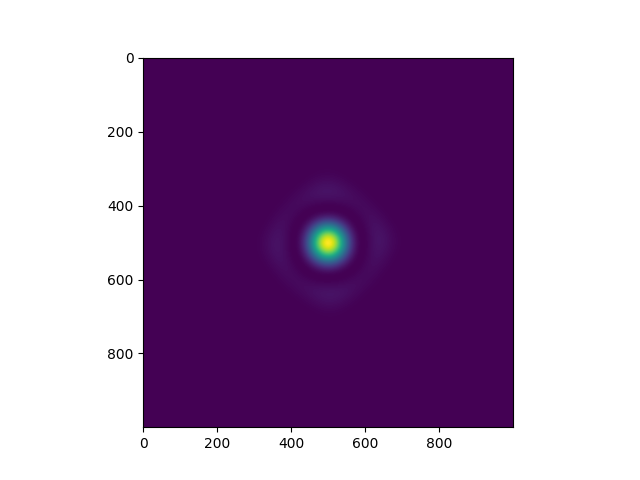

In [12]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(np.real(M_xds.M[0,0,0,:,:]))
plt.show()